In [311]:
import math
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from FeatureEngineering_2 import *

from joblib import dump, load
from AdvancedModel_helpers import *

In [2]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016,2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

  0%|          | 0/5456 [00:00<?, ?it/s]

100%|██████████| 5456/5456 [01:42<00:00, 53.04it/s] 


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [312]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '02']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df = train_val_df.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df.reset_index(drop=True)

Loading files: 100%|██████████| 4/4 [00:01<00:00,  2.36file/s]


In [313]:
train_val_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,...,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,Speed,x,y,angle_net,is_goal
0,2016020978,4,Shot,Wrist Shot,61.294372,9,0,0,Colorado Avalanche,1,...,0.0,9,45.453273,False,NaN,5.050364,-35.0,29.0,-28.237446,0
1,2016020978,5,Shot,Wrist Shot,8.944272,10,0,0,Colorado Avalanche,1,...,29.0,1,54.230987,True,-35.197503,54.230987,-85.0,8.0,-63.434949,0
2,2016020978,16,Shot,Wrist Shot,39.000000,243,0,0,Colorado Avalanche,1,...,35.0,43,108.853112,False,NaN,2.531468,-53.0,15.0,-22.619865,0
3,2016020978,17,Shot,Wrist Shot,39.962482,253,0,0,Carolina Hurricanes,1,...,15.0,10,108.166538,True,25.671421,10.816654,55.0,21.0,31.701430,0
4,2016020978,20,Shot,Wrist Shot,18.867962,349,0,0,Colorado Avalanche,1,...,-32.0,56,20.615528,False,NaN,0.368134,-79.0,-16.0,57.994617,0
5,2016020978,22,Goal,Wrist Shot,49.739320,368,0,1,Carolina Hurricanes,1,...,24.0,3,49.162994,False,NaN,16.387665,46.0,-25.0,-30.173520,1
6,2016020978,28,Shot,Wrist Shot,17.204651,484,0,1,Colorado Avalanche,1,...,-8.0,11,39.357337,False,NaN,3.577940,-75.0,10.0,-35.537678,0
7,2016020978,31,Shot,Wrist Shot,53.000000,551,0,1,Carolina Hurricanes,1,...,-22.0,31,25.709920,False,NaN,0.829352,44.0,-28.0,-31.890792,0
8,2016020978,35,Shot,Wrist Shot,60.033324,562,0,1,Carolina Hurricanes,1,...,29.0,3,59.076222,False,NaN,19.692074,37.0,-30.0,-29.981639,0
9,2016020978,36,Shot,Wrap-around,6.082763,592,0,1,Colorado Avalanche,1,...,-30.0,30,129.247824,True,67.145180,4.308261,-90.0,-6.0,80.537678,0


In [314]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay

### Training and Validation sets split

### 1. Train with only **Distance** and **Angle**

#### 1.1 Training and Validating

In [315]:
train_X_1,train_Y_1,val_X_1,val_Y_1 = split_data(train_val_df,['shot_dist','angle_net'],0.25,True)
train_X_1

,shot_dist,angle_net
24754,38.587563,31.0
243658,47.423623,42.0
128744,36.359318,-31.0
232598,51.478151,-7.0
164762,5.000000,36.0
...,...,...
183749,57.306195,-29.0
122080,37.443290,-55.0
180242,20.124612,26.0
44758,51.224994,-38.0


In [316]:
xgboost1= XGBClassifier()
xgboost1.fit(train_X_1, train_Y_1)
xgboost1_path = './models/xgboost1.joblib'
dump(xgboost1,xgboost1_path)

['./models/xgboost1.joblib']

#### 1.2

##### ROC AUC

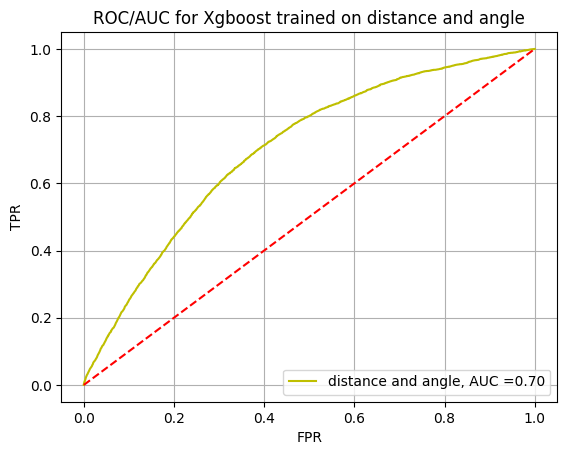

In [317]:
xgboost1=load(xgboost1_path)
val_res = xgboost1.predict_proba(val_X_1)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_1,val_res,'Xgboost','distance and angle')

In [318]:
precision_1 = metrics.precision_score(val_Y_1,xgboost1.predict(val_X_1))
recall_1= metrics.recall_score(val_Y_1,xgboost1.predict(val_X_1))

##### Goal rate

In [319]:
probas_and_label = helper_df(val_Y_1,val_res)
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
181289,0,0.687121,1,0.0,0.000000,100.000000,908446.303579,0.000000,0.000000
152914,1,0.648761,2,0.0,0.000000,99.995778,908446.303579,0.000000,0.000000
36967,1,0.648761,3,1.0,33.333333,99.995778,908446.303579,33.333333,0.003669
221389,0,0.648761,4,2.0,50.000000,99.995778,908446.303579,83.333333,0.009173
203069,1,0.648761,5,2.0,40.000000,99.995778,908446.303579,123.333333,0.013576
...,...,...,...,...,...,...,...,...,...
46325,0,0.001403,59207,5585.0,9.433006,0.008444,908446.303579,908408.573147,99.995847
45203,0,0.001317,59208,5585.0,9.432847,0.004222,908446.303579,908418.005994,99.996885
76933,0,0.001317,59209,5585.0,9.432688,0.004222,908446.303579,908427.438682,99.997923
184324,0,0.001317,59210,5585.0,9.432528,0.004222,908446.303579,908436.871210,99.998962


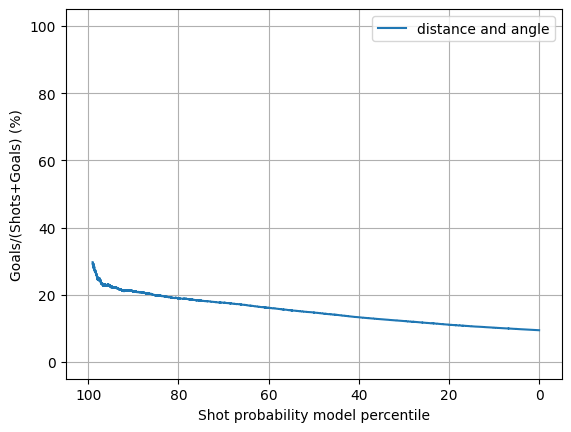

In [320]:
start_length = int(len(probas_and_label)*0.01)
plt.plot(probas_and_label['rank'].iloc[start_length:],probas_and_label['#goal/#goal+#shot'].iloc[start_length:],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

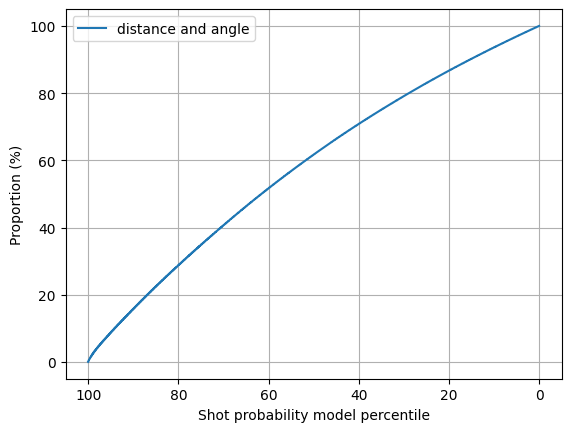

In [321]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

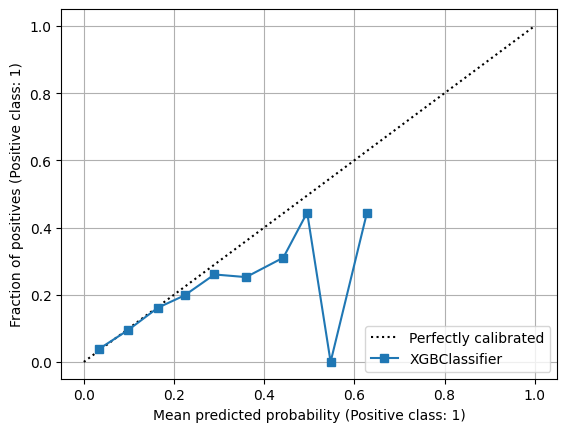

In [165]:
disp = CalibrationDisplay.from_estimator(xgboost1,val_X_1,val_Y,n_bins=15)
plt.grid(True)

### 2. Train with **features in part4**

In [322]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization

In [323]:
train_val_df_2=train_val_df[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'is_goal']]

##### One hot encoding 

In [324]:
train_val_2_shot_type_oh = onehot_generator(train_val_df_2[['shot_type']])
train_val_2_last_event_type_oh = onehot_generator(train_val_df_2[['last_event_type']])


In [325]:
train_val_df_2= train_val_df_2.drop(columns=['shot_type','last_event_type'])

In [326]:
train_val_df_2 = pd.concat([train_val_df_2,
                       train_val_2_shot_type_oh.set_index(train_val_df_2.index),
                       train_val_2_last_event_type_oh.set_index(train_val_df_2.index)],axis=1)

In [327]:
train_val_df_2

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,...,last_event_type_Missed Shot,last_event_type_Official Challenge,last_event_type_Penalty,last_event_type_Period End,last_event_type_Period Ready,last_event_type_Period Start,last_event_type_Shootout Complete,last_event_type_Shot,last_event_type_Stoppage,last_event_type_Takeaway
0,9,1,-35.0,29.0,0.0,0.0,9,45.453273,False,NaN,...,0,0,0,0,0,0,0,0,0,0
1,10,1,-85.0,8.0,-35.0,29.0,1,54.230987,True,-35.197503,...,0,0,0,0,0,0,0,1,0,0
2,243,1,-53.0,15.0,54.0,35.0,43,108.853112,False,NaN,...,0,0,0,0,0,0,0,0,0,0
3,253,1,55.0,21.0,-53.0,15.0,10,108.166538,True,25.671421,...,0,0,0,0,0,0,0,1,0,0
4,349,1,-79.0,-16.0,-66.0,-32.0,56,20.615528,False,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246273,1045,3,77.0,-23.0,-72.0,-21.0,21,149.013422,False,NaN,...,0,0,0,0,0,0,0,0,0,0
246274,1080,3,-76.0,38.0,-95.0,-17.0,16,58.189346,False,NaN,...,0,0,0,0,0,0,0,0,0,0
246275,1082,3,-79.0,10.0,-76.0,38.0,2,28.160256,True,26.113913,...,0,0,0,0,0,0,0,1,0,0
246276,1170,3,81.0,-7.0,-60.0,40.0,32,148.627050,False,NaN,...,1,0,0,0,0,0,0,0,0,0


In [328]:
train_X_2,train_Y_2,val_X_2,val_Y_2 = split_data(train_val_df_2,['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],0.25,False)

#### Hyperparameter tuning: Bayesian Optimization

###### ref:
######  https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
###### https://zhuanlan.zhihu.com/p/131216861

In [329]:
params = {
    'learning_rate':(0,1),
    'max_depth':(0,100),
    'min_child_weight':(0,10),
    'subsample':(0,1),
    'colsample_bytree': (0,1),
    'gamma':(0,10),
    'eta':(0,1),
    'n_estimators':(50,100)
}

In [330]:
def xgboost_opti(learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,eta,n_estimators):

    xgb = XGBClassifier(learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        eta=eta,
        n_estimators=int(n_estimators))

    cv_score = cross_val_score(xgb,train_X_2,train_Y_2,cv=3,scoring='roc_auc')
    
    return cv_score.mean()

xgb_bo = BayesianOptimization(f=xgboost_opti,pbounds=params,random_state=1)

In [331]:
xgb_bo.maximize()

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6771    | 0.417     | 0.7203    | 0.001144  | 0.3023    | 14.68     | 0.9234    | 59.31     | 0.3456    |
| 2         | 0.723     | 0.3968    | 0.5388    | 4.192     | 0.6852    | 20.45     | 8.781     | 51.37     | 0.6705    |
| 3         | 0.7258    | 0.4173    | 0.5587    | 1.404     | 0.1981    | 80.07     | 9.683     | 65.67     | 0.6923    |
| 4         | 0.7495    | 0.8764    | 0.8946    | 0.8504    | 0.03905   | 16.98     | 8.781     | 54.92     | 0.4211    |
| 5         | 0.7512    | 0.9579    | 0.5332    | 6.919     | 0.3155    | 68.65     | 8.346     | 50.91     | 0.7501    |
| 6         | 0.7319    | 0.8268    | 0.7575    | 7.182     | 0.5956    | 67.88     | 8.318     | 51.26     | 0.3354    |
| 7         | 0.7435    

In [333]:
best_param = xgb_bo.max['params']
best_param

{'colsample_bytree': 0.5647838996766793,
 'eta': 0.8086508162843394,
 'gamma': 9.73763558347701,
 'learning_rate': 0.0899607131650827,
 'max_depth': 47.16191209632081,
 'min_child_weight': 3.0710104703310384,
 'n_estimators': 55.5582866122662,
 'subsample': 0.7479929230375024}

In [334]:

best_param['n_estimators'] = int(best_param['n_estimators'])
best_param['max_depth'] = int(best_param['max_depth'])

In [335]:
xgboost2 = XGBClassifier(**best_param)

In [336]:
xgboost2.fit(train_X_2,train_Y_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5647838996766793, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8086508162843394, eval_metric=None, feature_types=None,
              gamma=9.73763558347701, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0899607131650827,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=47, max_leaves=None,
              min_child_weight=3.0710104703310384, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=55,
              n_jobs=None, num_parallel_tree=None, ...)

In [337]:
dump(xgboost2,'./models/xgboost2.joblib')

['./models/xgboost2.joblib']

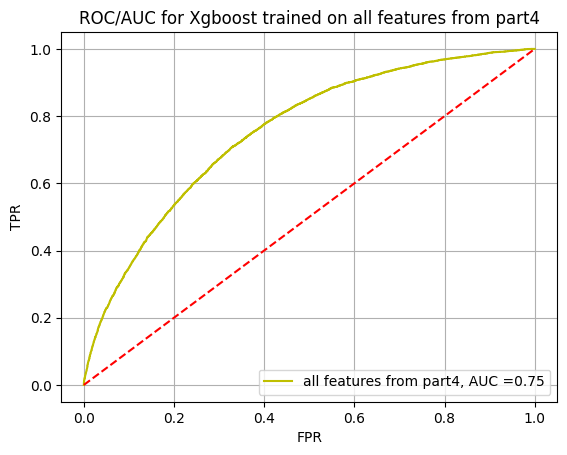

In [338]:
val_res_2 = xgboost2.predict_proba(val_X_2)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,val_res_2,'Xgboost','all features from part4')

In [339]:
probas_and_label_2 = helper_df(val_Y_2,val_res_2)
probas_and_label_2

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
127405,1,0.681526,1,0.0,0.000000,100.000000,1.119569e+06,0.000000e+00,0.000000
148177,1,0.679116,2,1.0,50.000000,99.998376,1.119569e+06,5.000000e+01,0.004466
30179,1,0.661604,3,2.0,66.666667,99.996752,1.119569e+06,1.166667e+02,0.010421
111771,1,0.653410,4,3.0,75.000000,99.995127,1.119569e+06,1.916667e+02,0.017120
40277,1,0.632112,5,4.0,80.000000,99.993503,1.119569e+06,2.716667e+02,0.024265
...,...,...,...,...,...,...,...,...,...
115720,0,0.011422,61566,5922.0,9.618946,0.012181,1.119569e+06,1.119530e+06,99.996563
177223,0,0.011422,61567,5922.0,9.618789,0.012181,1.119569e+06,1.119540e+06,99.997423
70343,0,0.011406,61568,5922.0,9.618633,0.004873,1.119569e+06,1.119550e+06,99.998282
159038,0,0.011311,61569,5922.0,9.618477,0.002436,1.119569e+06,1.119559e+06,99.999141


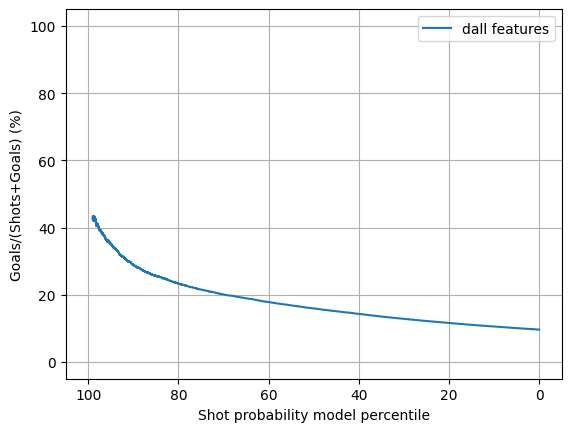

In [340]:
start_length = int(len(probas_and_label_2)*0.01)
plt.plot(probas_and_label_2['rank'].iloc[start_length:],probas_and_label_2['#goal/#goal+#shot'].iloc[start_length:],label="dall features")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

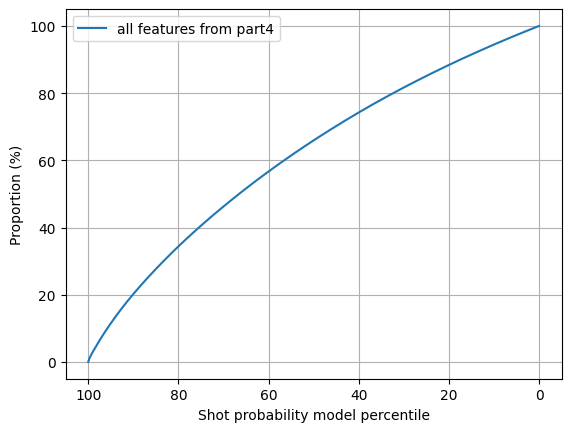

In [341]:
plt.plot(probas_and_label_2['rank'],probas_and_label_2['cum_percent'],label="all features from part4")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

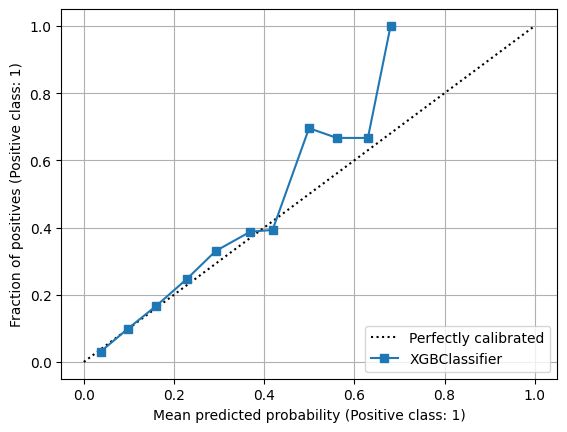

In [342]:
disp = CalibrationDisplay.from_estimator(xgboost2,val_X_2,val_Y_2,n_bins=15)
plt.grid(True)

### 3. Train with **feature selection**

###### ref:
https://scikit-learn.org/stable/modules/feature_selection.html


In [343]:
from sklearn.feature_selection import VarianceThreshold,RFE,SelectFromModel
from xgboost import plot_importance

##### a. Filter out low variance features

In [344]:
xgboost2_pretrained = XGBClassifier(**best_param)

In [345]:
t = 0.8*(1-0.8)
selector_1 = VarianceThreshold(t)
values = selector_1.fit_transform(train_X_2)
selector_1.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [371]:
train_X_3_filtered = train_X_2.loc[:,selector_1.get_support()]
val_X_3_filtered = val_X_2.loc[:,selector_1.get_support()]

In [372]:
xgboost_3_1 = xgboost2_pretrained.fit(train_X_3_filtered,train_Y_2)

In [373]:
val_res_3_1=xgboost_3_1.predict_proba(val_X_3_filtered)[:,1]
auc_3_1 = metrics.roc_auc_score(val_Y_2,val_res_3_1)

##### b.Recursive Feature Elimination(Wrapper method)

In [349]:
n_feature_in = len(train_X_2.columns)
n_feature_out = len(train_X_3_filtered.columns)

In [350]:
selector_2  = RFE(xgboost2_pretrained, n_features_to_select=n_feature_out, step=1)
selector_2= selector_2.fit(train_X_2,train_Y_2)

In [351]:
train_X_3_rfe = train_X_2.loc[:,selector_2.support_]
val_X_3_rfe = val_X_2.loc[:,selector_2.support_]
train_X_3_rfe

,game_time,period,x,y,y_coord_last_event,Time_from_the_last_event,Rebound,Speed,angle_net,shot_type_Tip-In,last_event_type_Faceoff,last_event_type_Hit,last_event_type_Stoppage
19167,338,2,-54.0,13.0,-2.0,5,True,5.491812,-20.0,0,0,0,0
137481,247,4,79.0,7.0,11.0,37,True,0.367607,34.0,0,0,0,0
85907,435,3,85.0,14.0,-4.0,14,True,10.862076,74.0,0,0,0,0
236488,66,1,-84.0,-23.0,-24.0,10,True,2.002498,77.0,0,0,0,0
158944,929,3,-35.0,-26.0,-38.0,10,False,8.584288,25.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176963,208,2,-45.0,-15.0,0.0,12,False,3.952847,18.0,0,1,0,0
117952,1186,3,-38.0,-20.0,2.0,6,False,4.737557,21.0,0,0,0,0
173685,177,3,67.0,-1.0,-6.0,34,False,4.796373,-2.0,0,0,0,0
43567,999,3,32.0,-29.0,-13.0,6,False,5.520165,-26.0,0,0,0,0


In [352]:
xgboost_3_2 = xgboost2_pretrained.fit(train_X_3_rfe,train_Y_2)

In [353]:
val_res_3_2=xgboost_3_2.predict_proba(val_X_3_rfe)[:,1]
auc_3_2 = metrics.roc_auc_score(val_Y_2,val_res_3_2)
auc_3_2

0.7469253623975783

##### L1-based feature selection

In [354]:
selector3 = SelectFromModel(xgboost2,prefit=True)

In [355]:
X_new = selector3.fit_transform(train_X_2)

In [356]:
train_X_3_sfm=train_X_2.loc[:,selector3.get_support()]
val_X_3_sfm=val_X_2.loc[:,selector3.get_support()]

In [357]:
xgboost_3_3 = xgboost2_pretrained.fit(train_X_3_sfm,train_Y_2)

In [358]:
val_res_3_3=xgboost_3_3.predict_proba(val_X_3_sfm)[:,1]
auc_3_3 = metrics.roc_auc_score(val_Y_2,val_res_3_3)

In [359]:
auc_3_3

0.7326133113890583

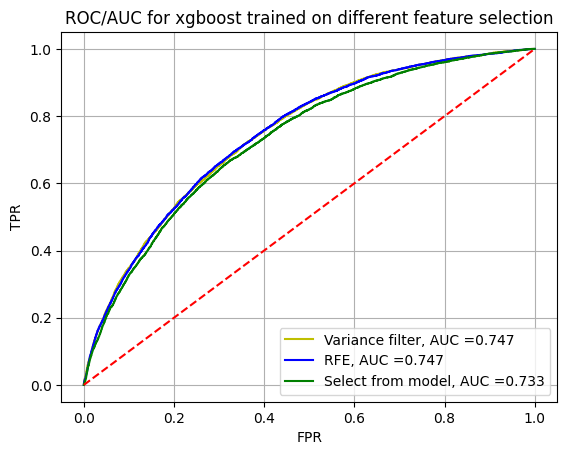

In [361]:
fpr_3_1,tpr_3_1,threshold_3_1 = metrics.roc_curve(val_Y_2,val_res_3_1)
fpr_3_2,tpr_3_2,threshold_3_2 = metrics.roc_curve(val_Y_2,val_res_3_2)
fpr_3_3,tpr_3_3,threshold_3_3 = metrics.roc_curve(val_Y_2,val_res_3_3)

auc_3_1 = metrics.auc(fpr_3_1,tpr_3_1)
auc_3_2 = metrics.auc(fpr_3_2,tpr_3_2)
auc_3_3 = metrics.auc(fpr_3_3,tpr_3_3)

plt.title(f'ROC/AUC for xgboost trained on different feature selection')
plt.plot(fpr_3_1,tpr_3_1,'y',label=f"Variance filter, AUC =%0.3f"%auc_3_1)
plt.plot(fpr_3_2,tpr_3_2,'b',label=f"RFE, AUC =%0.3f"%auc_3_2)
plt.plot(fpr_3_3,tpr_3_3,'g',label=f"Select from model, AUC =%0.3f"%auc_3_3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid(True)
plt.legend(loc="lower right")

##### Filter method is faster and as good as RFE method, we will choose these features and do hyperparam tuning

In [362]:
train_X_3_selected = train_X_3_filtered

In [363]:
xgboost3 = xgboost_3_1

In [366]:
val_X_2

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,...,last_event_type_Missed Shot,last_event_type_Official Challenge,last_event_type_Penalty,last_event_type_Period End,last_event_type_Period Ready,last_event_type_Period Start,last_event_type_Shootout Complete,last_event_type_Shot,last_event_type_Stoppage,last_event_type_Takeaway
228054,216,1,76.0,-4.0,46.0,15.0,5,35.510562,False,NaN,...,0,0,0,0,0,0,0,0,0,0
80896,660,3,-32.0,31.0,0.0,0.0,25,44.553339,False,NaN,...,0,0,0,0,0,0,0,0,0,0
132850,471,2,-47.0,29.0,-73.0,4.0,15,36.069378,False,NaN,...,0,0,0,0,0,0,0,0,0,0
139674,1092,3,-60.0,16.0,91.0,30.0,5,151.647618,False,NaN,...,0,0,0,0,0,0,0,0,0,0
32185,1227,3,81.0,-1.0,14.0,-8.0,0,67.364679,False,NaN,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125710,296,2,-75.0,5.0,-97.0,40.0,3,41.340053,False,NaN,...,0,0,0,0,0,0,0,0,0,0
36158,331,1,-56.0,-18.0,53.0,40.0,22,123.470644,False,NaN,...,0,0,0,0,0,0,0,0,0,0
26090,151,2,39.0,19.0,69.0,22.0,31,30.149627,False,NaN,...,0,0,0,0,0,0,0,0,0,0
18833,197,2,68.0,6.0,95.0,-1.0,23,27.892651,False,NaN,...,0,0,0,0,0,0,0,0,0,0


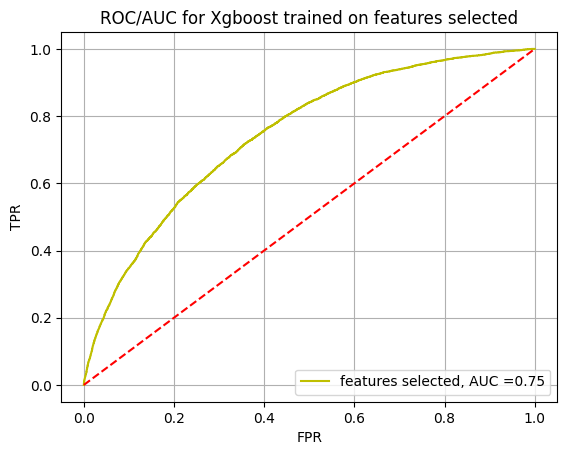

In [375]:
val_res_3 = xgboost3.predict_proba(val_X_3_filtered)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,val_res_3,'Xgboost','features selected')

In [376]:
probas_and_label_3 = helper_df(val_Y_2,val_res_3)
probas_and_label_3

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
148177,1,0.643183,1,0.0,0.000000,100.000000,1.103564e+06,0.000000e+00,0.000000
30179,1,0.636191,2,1.0,50.000000,99.998376,1.103564e+06,5.000000e+01,0.004531
213820,0,0.614491,3,2.0,66.666667,99.996752,1.103564e+06,1.166667e+02,0.010572
232066,1,0.607111,4,2.0,50.000000,99.995127,1.103564e+06,1.666667e+02,0.015103
67957,1,0.591221,5,3.0,60.000000,99.993503,1.103564e+06,2.266667e+02,0.020540
...,...,...,...,...,...,...,...,...,...
163226,0,0.012510,61566,5922.0,9.618946,0.007309,1.103564e+06,1.103525e+06,99.996514
233700,0,0.012510,61567,5922.0,9.618789,0.007309,1.103564e+06,1.103535e+06,99.997385
101445,0,0.012434,61568,5922.0,9.618633,0.003248,1.103564e+06,1.103544e+06,99.998257
98282,0,0.012434,61569,5922.0,9.618477,0.003248,1.103564e+06,1.103554e+06,99.999128


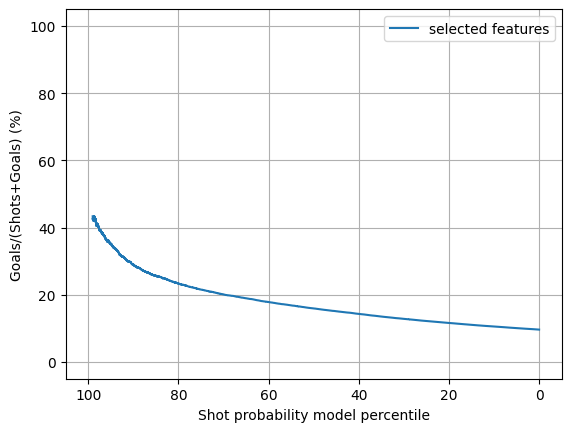

In [377]:
start_length = int(len(probas_and_label_3)*0.01)
plt.plot(probas_and_label_2['rank'].iloc[start_length:],probas_and_label_2['#goal/#goal+#shot'].iloc[start_length:],label="selected features")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

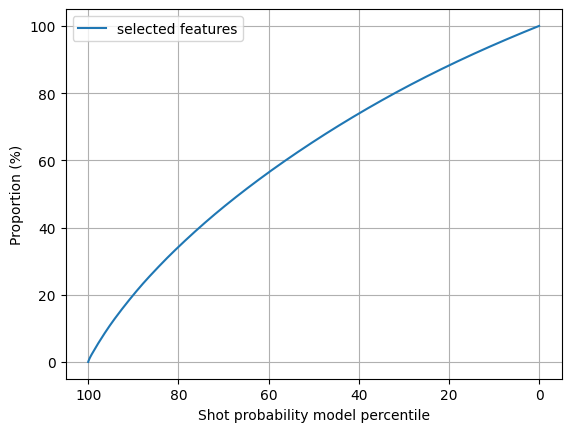

In [378]:
plt.plot(probas_and_label_3['rank'],probas_and_label_3['cum_percent'],label="selected features")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

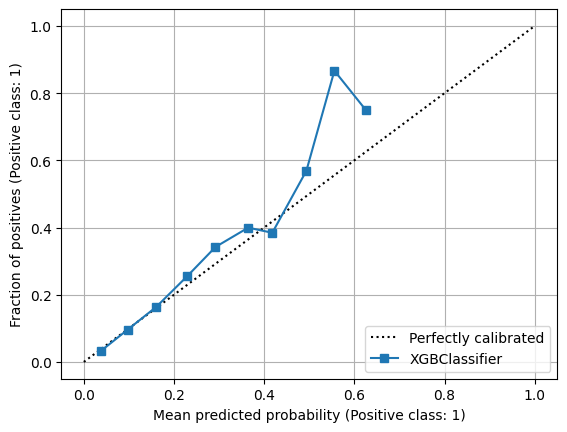

In [379]:
disp = CalibrationDisplay.from_estimator(xgboost3,val_X_3_filtered,val_Y_2,n_bins=15)
plt.grid(True)

In [380]:
dump(xgboost3,'./models/xgboost3.joblib')

['./models/xgboost3.joblib']